In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import folium
import cv2 as cv

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

#from torchvision.datasets import ImageFolder

#from torch.utils.data import Dataset, DataLoader

In [2]:
class NO2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files_list = [s for s in os.listdir(root_dir)]
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        index = index + (lag+1)
        
        band = np.zeros((lag+1, 148,480))
        # path to image
        for i in range(lag+1):
            path_to_image = os.path.join(self.root_dir, self.image_files_list[index-i])
        
            # get image and image band
            image= rio.open(path_to_image)
             # add padding
            band[i,:,:-5] = image.read(2)
        
        band = torch.tensor(band)
        return band, image.name
    
    def __len__(self):
        return len(self.image_files_list)-(lag+1)

In [3]:
path = './eie_data/cleaned_s5p_no2/'
transform = transforms.Compose(
    [transforms.ToTensor()]
)
# Dataset
data = NO2Dataset(path, transform)

In [4]:
batch_size = 4
lag = 3

# Data laoder
train_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
dataiter = iter(train_loader)

In [6]:
next(dataiter)[0].shape

torch.Size([4, 4, 148, 480])

In [7]:
torch.tensor(np.array([[[2,1],[1,2]], [[2,1],[1,2]], [[2,1],[1,2]]])).shape

torch.Size([3, 2, 2])

## Scale data to [-1,1]:

In [8]:
mn = 0.0
mx = 6.750725398368169e-05

def scale(x, mn=mn, mx=mx):
    ''' Scale takes in an image x and returns that image, scaled
        from 0-1.'''
    
    # scale from 0-1 to feature_range
    x = 2*((x-mn)/mx)-1
    return x

def rescale(x, mn=mn, mx=mx):
    ''' Rescale takes in an image x and returns that image, scaled
        from 0-1.'''
    
    # rescale to original range:
    x=0.5*(x+1)*mx+mn
    return x

---

## Define architecture:

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
# residual block class
class ResidualBlock(nn.Module):
    
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

## Network

In [13]:
class Net(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=3):
        super(Net, self).__init__()
        flat_network = True
        
        # 1. Define the encoder part
        # initial convolutional layer given, below
        self.conv1 = conv(lag, conv_dim, kernel_size=4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4, padding=(2,1))
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part
        # Residual blocks
        res_layers = []
        if flat_network:
            for layer in range(n_res_blocks):
                res_layers.append(ResidualBlock(conv_dim))
        else:
            for layer in range(n_res_blocks):
                res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4, padding=(2,1))
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 1, kernel_size=4, batch_norm=False)
        
        
    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        
        # x: [1, lag, 148, 480]
        out = self.conv1(x) # [1, 64, 74, 240]
        #print(out.shape)
        #out = F.relu(self.conv2(out)) # [1, 128, 38, 120]
        #print(out.shape)
        #out = F.relu(self.conv3(out)) # [1, 256, 19, 60]
        #print(out.shape)
        out = self.res_blocks(out) # [1, 256, 19, 60]
        #print(out.shape)
        #out = F.relu(self.deconv1(out)) # [1, 128, 38, 120]
        #print(out.shape)
        #out = F.relu(self.deconv2(out)) # [1, 64, 74, 240]
        #print(out.shape)
        #out = self.deconv3(out) # [1, 1, 148, 480]
        #print(out.shape)
        # tanh applied to last layer
        out = self.deconv3(out)
        return out


net = Net(conv_dim=64, n_res_blocks=6).double()

# move models to GPU, if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    net.to(device)
    print('Models moved to GPU.')
else:
    print('Only CPU available.')

Models moved to GPU.


## Training criteria:

In [14]:
import torch.optim as optim

#lr= 0.00001

lr= 1e-04
beta1=0.5
beta2=0.99

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(list(net.parameters()), lr, [beta1, beta2])

## Train network

In [171]:
def trainingLoop(dataloader, epochs=1):
    printEvery = 20
    train_errors = []
    
    for epoch in range(epochs):
        iter_X = iter(dataloader)
        
        # Move to GPU:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        for i, item in enumerate(iter_X):
            # One step prediction target:
            batch = scale(item[0])
            train_X = batch[:,:-1,:,:]
            target_X = batch[:,-1,:,:]
            # Move target to GPU:
            train_X = train_X.to(device)
            target_X = target_X.to(device)
            
            #print(target_X)
            # forward, loss, backward and optimize:
            out = net(train_X)
            #print(out)
            loss = criterion(out, target_X)
            #print("loss ", float(loss))
            loss.backward()
            optimizer.step()
            
            # log the train error for graph
            train_errors.append([epoch, i, loss])
            if i%printEvery==0:
                print("Train loss epoch ", epoch, " nr. ", i, " is: ", str(loss))
    return train_errors
    

In [172]:
epochs=20
t_erros1 = trainingLoop(train_loader, epochs=epochs)

loss  31.883863942642176
Train loss epoch  0  nr.  0  is:  tensor(31.8839, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward>)
loss  22.52316117959555
loss  19.306836284408462
loss  16.870263375990277
loss  14.915693050446261
loss  15.29433307824406
loss  13.141753882823377
loss  13.039404439534954
loss  11.856317578194364
loss  14.691192949721682
loss  14.313414423657196
loss  11.205390506324267
loss  8.51127772024443
loss  8.72202728900045
loss  12.59367918503831
loss  15.003570027787475
loss  14.929513486605074
loss  10.521322901030821
loss  6.657498055748299
loss  5.958425219284663
loss  8.329369557567164
Train loss epoch  0  nr.  20  is:  tensor(8.3294, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  13.346330885040977
loss  18.42163288069634
loss  16.273136578038855
loss  13.427870790166558
loss  9.496676880050442
loss  9.127029831696321
loss  6.665288821529999
loss  7.336559483683384
loss  9.25263445762566
loss  11.381610632424255
loss 

loss  0.5460299885530313
loss  0.4926666156630578
loss  0.5514050435528931
loss  0.5491490783679838
loss  0.7758265798107592
loss  0.5353231866790791
loss  0.531559205714261
loss  0.6140561831890088
loss  0.5954862698171849
loss  0.5256216301351497
loss  0.4765036267912788
Train loss epoch  3  nr.  40  is:  tensor(0.4765, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.5073171468650952
loss  0.5327697900476995
loss  0.2964928535950016
loss  0.47174871648576117
loss  0.48552163313376534
loss  0.5262086960391661
loss  0.5150998865719179
loss  0.4388343260354847
loss  0.48609947064819936
loss  0.43252882536866943
loss  0.446082558260137
loss  0.3612695710466879
loss  0.4381956072693783
loss  0.4531290495659875
loss  0.4355133467764395
loss  0.3569216659532838
loss  0.35873666360761497
loss  0.3818957035745292
loss  0.31473730762829916
loss  0.3292219730634498
Train loss epoch  3  nr.  60  is:  tensor(0.3292, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBa

loss  0.17373480605112454
loss  0.15734703945956233
loss  0.1837552679660704
loss  0.16975199076937067
Train loss epoch  6  nr.  60  is:  tensor(0.1698, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.1724634510509902
loss  0.15540531647414596
loss  0.16072372190451137
loss  0.1904227057381223
loss  0.167830954370507
loss  0.23802019486808557
loss  0.1809526584191181
loss  0.17805220646135528
loss  0.1658760187405379
loss  0.147295909008984
loss  0.17443070219828422
loss  0.1563359423213354
loss  0.1696886943035307
loss  0.16527260790717643
loss  0.6436703833820058
loss  0.22897496215567822
loss  0.16208690230656816
loss  0.18228033830138063
loss  0.1934725557340139
Train loss epoch  7  nr.  0  is:  tensor(0.1935, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.17357417386231638
loss  0.18571357634382177
loss  0.17963158628909812
loss  0.20684945204183097
loss  0.17406448137514793
loss  0.1725166128102105
loss  0.15278931503923687
loss 

loss  0.1035105595109235
loss  0.10665719889948908
loss  0.11992793142616946
loss  0.12306259599926338
loss  0.13101485296982388
loss  0.15201716245391636
loss  0.12231563062274707
loss  0.12615305369545532
loss  0.15394161985458416
loss  0.26690287013548464
loss  0.6207135621447586
loss  0.17692002582773148
loss  0.19259720458565527
loss  0.14032189173205772
loss  0.13768126422591326
loss  0.11536517732093314
loss  0.13081981317134497
loss  0.11402538339637153
loss  0.12946119386746216
loss  0.1276478807947341
Train loss epoch  10  nr.  20  is:  tensor(0.1276, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.11495517163684901
loss  0.1376587550222851
loss  0.11701749188838435
loss  0.11926244733710632
loss  0.13564406791482697
loss  0.11587165488723698
loss  0.14607974900637288
loss  0.16411744581634696
loss  0.10939164864699931
loss  0.10230092395831379
loss  0.10649625373899027
loss  0.10792809211266818
loss  0.12397944497665316
loss  0.11052522813728292
loss

loss  0.08667004436379566
loss  0.08457738145701035
loss  0.09099414995172794
loss  0.09161175290663337
loss  0.08092365221795476
loss  0.25835212869969815
loss  0.0783448894729394
loss  0.07998734233514303
loss  0.08580401689741259
loss  0.08970415284710456
loss  0.09279546707476485
loss  0.13598614051040236
loss  0.09801244507407268
loss  0.09571911174451377
loss  0.2621746734851724
loss  0.08208890047254927
loss  0.07555906318550108
Train loss epoch  13  nr.  40  is:  tensor(0.0756, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.09421532502219743
loss  0.08548594866915786
loss  0.10864133917090223
loss  0.08004214619909661
loss  0.5815157231216717
loss  0.09651131263155058
loss  0.09355038278546605
loss  0.09381089900452877
loss  0.11239918292497886
loss  0.09816618387564696
loss  0.08956980887697125
loss  0.13396735940534854
loss  0.22024347392995963
loss  0.137339140592751
loss  0.12974763907964118
loss  0.16155223075469471
loss  0.1332491218726474
loss  

loss  0.09856503068220443
loss  0.14010766340085962
loss  0.31870319457044943
loss  0.10053347236613006
loss  0.25303967050306436
loss  0.08432472877969406
loss  0.0937093913934087
loss  0.08140710101640335
loss  0.08179751089766374
loss  0.08046485430871304
loss  0.08315856836198045
loss  0.14238660459793587
loss  0.10206390626853776
loss  0.10219426798802586
Train loss epoch  16  nr.  60  is:  tensor(0.1022, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.08290410952908644
loss  0.09455437989487682
loss  0.08386905369304933
loss  0.11335159682661178
loss  0.0903710222905861
loss  0.0836684917766102
loss  0.07938711915715105
loss  0.0798217270577883
loss  0.12641640018441053
loss  0.09833068842712536
loss  0.12185179447739813
loss  0.11883719699807577
loss  0.1498712474149517
loss  0.12426136746382326
loss  0.09872331945930833
loss  0.15467262230954665
loss  0.14634624628432175
loss  0.11096718692075262
loss  0.0915078119144246
Train loss epoch  17  nr.  0  is

loss  0.15512094808098312
loss  0.09775911862233218
loss  0.10577263851711521
loss  0.10398697605260794
loss  0.1114167133968237
loss  0.11624332195473357
loss  0.09924896841662638
loss  0.1051348310975023
loss  0.102785474383092


In [16]:
epochs=3
#t_erros2 = trainingLoop(train_loader, epochs=epochs)

loss  1.619212182038105
Train loss epoch  0  nr.  0  is:  tensor(1.6192, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  1.623280801360591
loss  1.5213770741465564
loss  1.5933214633717887
loss  1.6255423223806866
loss  1.4996868063856115
loss  1.3531108280924276
loss  1.490417208691743
loss  1.4022154741055348
loss  1.4301021289776175
loss  1.5661902396691303
loss  1.3273077636642323
loss  1.3027200773994896
loss  1.3489764172502252
loss  1.1935026508077358
loss  1.3064437332832515
loss  1.3262667209882084
loss  1.729355084204898
loss  1.1913935937703513
loss  1.361401286360256
loss  1.1472529901660773
Train loss epoch  0  nr.  20  is:  tensor(1.1473, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  1.1052995133859982
loss  1.0904469101707266
loss  1.038108018350519
loss  1.1297431685608748
loss  1.027508163545102
loss  1.0143181412670028
loss  1.0243437704471021
loss  0.9855220455799867
loss  1.0428062469743402
loss  1.0478592460619438
los

In [17]:
epochs=3
#t_erros3 = trainingLoop(train_loader, epochs=epochs)

loss  0.21930977625979958
Train loss epoch  0  nr.  0  is:  tensor(0.2193, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.2435148568583175
loss  0.2466547078422275
loss  0.25353094711247487
loss  0.20716470914806742
loss  0.22370341957471693
loss  0.22997266484117876
loss  0.25278605444977875
loss  0.25975064930551184
loss  0.21805136021951443
loss  0.2308258868116317
loss  0.22709642618155668
loss  0.2370313586257092
loss  0.24175818592182532
loss  0.24495803588070678
loss  0.26110383299848305
loss  0.3273125979313069
loss  0.2209979174713063
loss  0.250790458755778
loss  0.22513435825203554
loss  0.2088942282231222
Train loss epoch  0  nr.  20  is:  tensor(0.2089, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
loss  0.44905225408166055
loss  0.2216608136658871
loss  0.326653360931035
loss  0.22636649422722732
loss  0.19749712909460598
loss  0.25247372575849236
loss  0.22360498550200839
loss  0.2323746012261778
loss  0.25095584224320044
loss

In [ ]:
err = np.array(t_erros1)

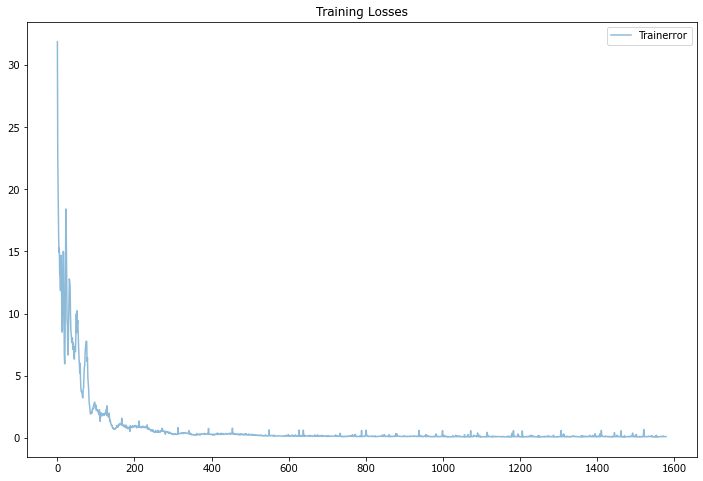

In [176]:
# Plot training development:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(err, label='Trainerror', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [21]:
m = [0,0,0]
for i, item in enumerate(t_erros):
    if item[2] > m[2]:
        m=item

## Load pictures and show prediction vs. real

In [234]:
# Load random input for lag

# Pass input to network

# Visualize the output along with the picture, and the difference.
net.eval()
dataiter = iter(train_loader)
#inpt1 = scale(dataiter.next()[0])
#inpt2 = scale(dataiter.next()[0])
#inpt3 = scale(dataiter.next()[0])
#target = scale(dataiter.next()[0])

batch = scale(dataiter.next()[0])
print(batch.shape)
train_X = batch[:,:-1,:,:]
print(train_X.shape)
target_X = batch[:,-1,:,:]
print(target_X.shape)
inpt = train_X.to(device)
pred = net(inpt)
print(pred.shape)
net.train()
print(toNP(target_X).shape)

torch.Size([4, 4, 148, 480])
torch.Size([4, 3, 148, 480])
torch.Size([4, 148, 480])
torch.Size([4, 1, 148, 480])
(148, 480)


## Visualization

In [235]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import rasterio as rio
import folium
import cv2 as cv

import matplotlib.cm as cm
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

lat=18.200178; lon=-66.064513
def overlay_image_on_puerto_rico(data, band_layer=2, cmap=lambda x: (1, 0, 0, x)):
    band = data
    m = folium.Map([lat, lon], zoom_start=9.45)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap = cmap,
        origin='lower'
    ).add_to(m)
    return m

def toNP(data):
    return(rescale(data[0].data.cpu().numpy().reshape((148,480))))

# Choose colormap
cmap = cm.get_cmap('Reds')
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

mn = 0.0
mx = 6.750725398368169e-05
norm = matplotlib.colors.Normalize(vmin=mn, vmax=mx, clip=False)
cmap = cm.ScalarMappable(norm=norm, cmap=my_cmap)

In [236]:
overlay_image_on_puerto_rico(toNP(pred), cmap=cmap.to_rgba)

In [237]:
overlay_image_on_puerto_rico(toNP(target_X), cmap=cmap.to_rgba)

## Histogram example:

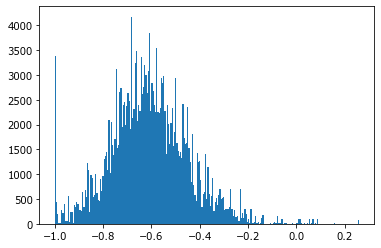

In [238]:
plt.hist(train_X[0,:,:,:].flatten(), bins=255)
plt.show()

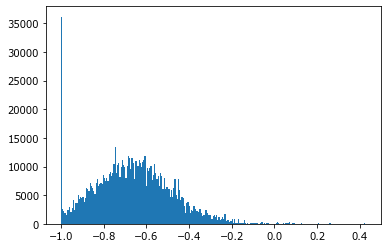

In [248]:
plt.hist(train_X[:,:,:,:].flatten(), bins=255)
plt.show()

In [52]:
path = './eie_data/cleaned_s5p_no2/'
data = NO2Dataset(path, transform)
train_loader = DataLoader(dataset=data, batch_size=1, shuffle=False, num_workers=0)
dataiter = iter(train_loader)
n=dataiter.next()[0].data.numpy()[0,0,:,:]

for i, batch in enumerate(dataiter):
    b = batch[0].data.numpy()[0,0,:,:]
    n = np.concatenate((n, b), axis=0)


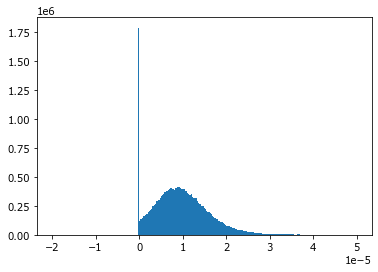

In [55]:
f = n.flatten()
#print(len(f))
#f = f[~np.isnan(f)]
plt.hist(f[~np.isnan(f)], bins=255, range=(-0.00002, 0.00005))
plt.show()

24753935